Epoch 1/20


C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


772/772 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.8671 - loss: 0.3319 - val_accuracy: 0.9384 - val_loss: 0.1708
Epoch 2/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9382 - loss: 0.1785 - val_accuracy: 0.9588 - val_loss: 0.1219
Epoch 3/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9519 - loss: 0.1364 - val_accuracy: 0.9711 - val_loss: 0.0914
Epoch 4/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9631 - loss: 0.1070 - val_accuracy: 0.9739 - val_loss: 0.0848
Epoch 5/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9687 - loss: 0.0891 - val_accuracy: 0.9749 - val_loss: 0.0744
Epoch 6/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9746 - loss: 0.0725 - val_accuracy: 0.9813 - val_loss: 0.0594
Epoch 7/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9780 - loss: 0.0622 - val_accuracy: 0.9836 - val_loss: 0.0509
Epoch 8/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9800 - loss: 0.0585 - val_accurac

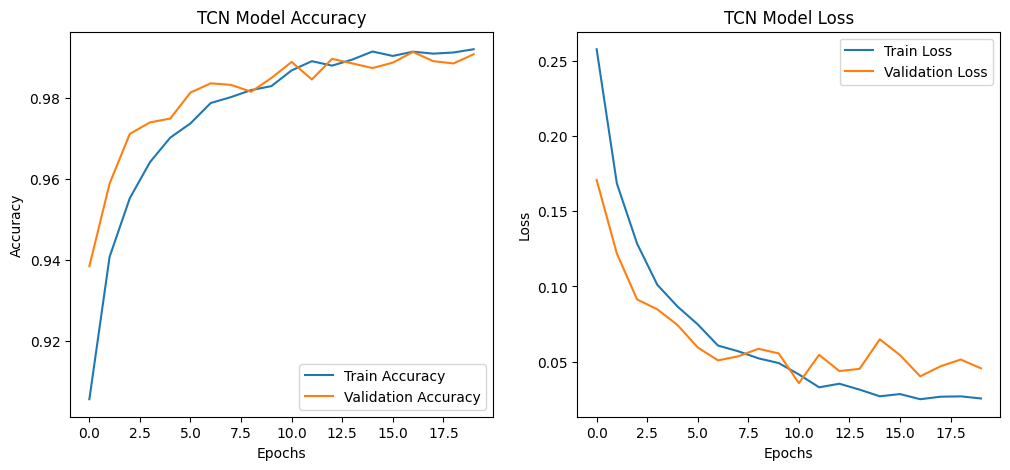

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


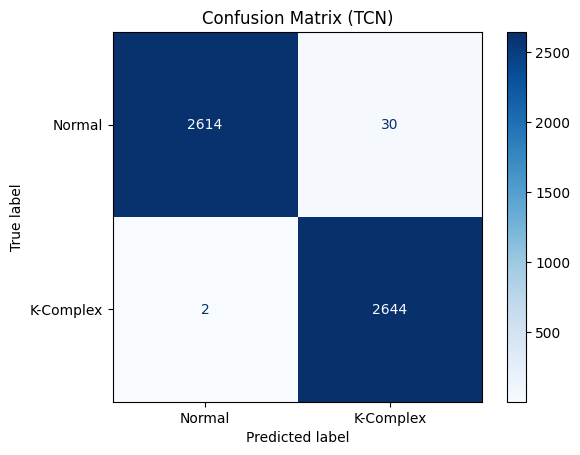

Classification Report (TCN):
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99      2644
   K-Complex       0.99      1.00      0.99      2646

    accuracy                           0.99      5290
   macro avg       0.99      0.99      0.99      5290
weighted avg       0.99      0.99      0.99      5290



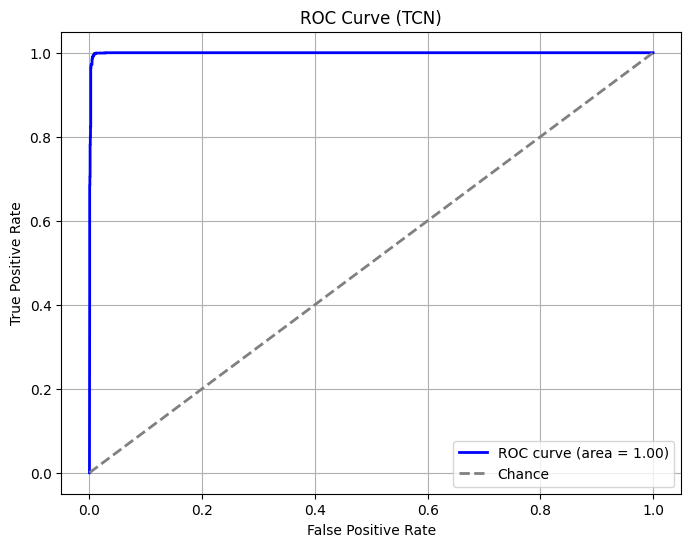

NameError: name 'b' is not defined

In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import shap

# --- Data Loading ---
# Path where all your files are stored
folder_path = 'D:/OneDrive_2024-12-27/Segmented by seperating spindles/Balanced_segmented/'

# Collect all Excel file paths in the folder
file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.xlsx')]

# Initialize empty lists to store features and labels
X_list, y_list = [], []

# Load and combine data from all files
for file_path in file_paths:
    data = pd.read_excel(file_path)
    X_list.append(data.iloc[:, :-1].values)  # All columns except the last
    y_list.append(data.iloc[:, -1].values)  # The last column

# Concatenate data from all files
X = np.vstack(X_list)
y = np.hstack(y_list)

# --- Data Preprocessing ---
# Normalize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data for CNN (add a channel dimension)
X_scaled_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled_reshaped, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Convert labels to categorical format
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

# --- Model Building ---
model_tcn = Sequential([
    Conv1D(64, kernel_size=3, dilation_rate=1, activation='relu', padding='causal', input_shape=(X_train.shape[1], 1)),
    SpatialDropout1D(0.2),
    MaxPooling1D(pool_size=2),
    
    Conv1D(128, kernel_size=3, dilation_rate=2, activation='relu', padding='causal'),
    SpatialDropout1D(0.2),
    MaxPooling1D(pool_size=2),
    
    Conv1D(256, kernel_size=3, dilation_rate=4, activation='relu', padding='causal'),
    SpatialDropout1D(0.3),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Output layer for binary classification
])

# Compile the model
model_tcn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Model Training ---
history_tcn = model_tcn.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=20,
    batch_size=32,
    verbose=1
)

# --- Model Evaluation ---
test_loss_tcn, test_accuracy_tcn = model_tcn.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Loss (TCN): {test_loss_tcn:.4f}")
print(f"Test Accuracy (TCN): {test_accuracy_tcn:.4f}")

# Visualize training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_tcn.history['accuracy'], label='Train Accuracy')
plt.plot(history_tcn.history['val_accuracy'], label='Validation Accuracy')
plt.title('TCN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_tcn.history['loss'], label='Train Loss')
plt.plot(history_tcn.history['val_loss'], label='Validation Loss')
plt.title('TCN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# --- Confusion Matrix and Classification Report ---
y_pred_tcn = model_tcn.predict(X_test)
y_pred_classes_tcn = np.argmax(y_pred_tcn, axis=1)

conf_matrix_tcn = confusion_matrix(y_test, y_pred_classes_tcn)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_tcn, display_labels=['Normal', 'K-Complex'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (TCN)")
plt.show()

report_tcn = classification_report(y_test, y_pred_classes_tcn, target_names=['Normal', 'K-Complex'])
print("Classification Report (TCN):")
print(report_tcn)

# --- ROC Curve and AUC ---
fpr_tcn, tpr_tcn, _ = roc_curve(y_test_cat[:, 1], y_pred_tcn[:, 1])
roc_auc_tcn = auc(fpr_tcn, tpr_tcn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_tcn, tpr_tcn, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_tcn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (TCN)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# --- SHAP Explainable AI ---
# Prepare SHAP background and test samples
# Prepare SHAP background and test samples
background_tcn = X_train[np.random.choice(X_train.shape[0], 50, replace=False)]  # Random background samples
test_samples_tcn = X_test[:10]  # First 10 test samples


# Wrapper function for SHAP
# Wrapper function for SHAP
def tcn_predict_wrapper(data):
    return model_tcn.predict(data.reshape(-1, X_train.shape[1], 1))

# Initialize SHAP Kernel Explainer
explainer_tcn = shap.KernelExplainer(tcn_predict_wrapper, background_tcn)

# Generate SHAP values for test samples
shap_values_tcn = explainer_tcn.shap_values(test_samples_tcn)

# Plot SHAP summary
shap.summary_plot(shap_values_tcn[0], test_samples_tcn.reshape(test_samples_tcn.shape[0], -1),
                  feature_names=[f"Feature {i}" for i in range(X_train.shape[1])])


In [5]:
print(f"Shape of shap_values_tcn: {shap_values_tcn[0].shape}")
print(f"Shape of test_samples_tcn_flattened: {test_samples_tcn_flattened.shape}")


Shape of shap_values_tcn: (200, 2)
Shape of test_samples_tcn_flattened: (10, 200)


Shape of reshaped shap_values_tcn_class_0: (10, 200)
Shape of test_samples_tcn_flattened: (10, 200)


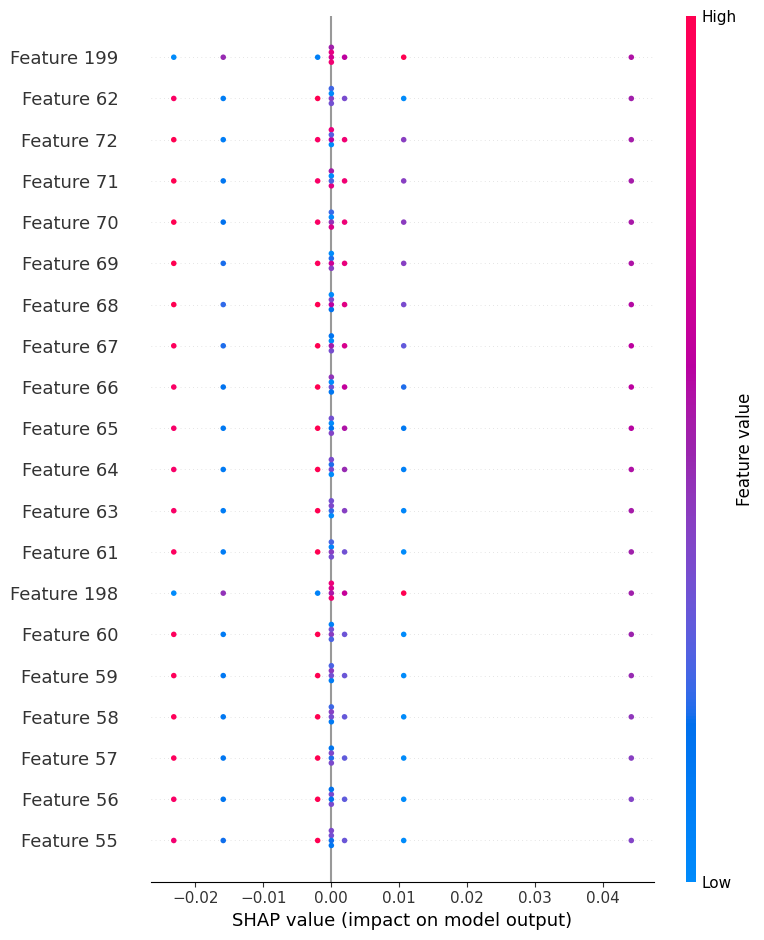

In [15]:
# Reshape shap_values_tcn_class_0 to match the number of features (200 features per sample)
shap_values_tcn_class_0_reshaped = shap_values_tcn_class_0.repeat(200, axis=1)  # Replicate across 200 features

# Ensure the correct shape after replication
print(f"Shape of reshaped shap_values_tcn_class_0: {shap_values_tcn_class_0_reshaped.shape}")  # Should be (10, 200)

# Flatten the test samples as before
test_samples_tcn_flattened = test_samples_tcn.reshape(test_samples_tcn.shape[0], -1)

# Ensure the correct shape of test samples
print(f"Shape of test_samples_tcn_flattened: {test_samples_tcn_flattened.shape}")  # Should be (10, 200)

# Plot SHAP summary for class 0
# Since we've reshaped shap_values_tcn_class_0 to match the number of features
shap.summary_plot(shap_values_tcn_class_0_reshaped, test_samples_tcn_flattened,
                  feature_names=[f"Feature {i}" for i in range(test_samples_tcn_flattened.shape[1])])
